# Timing

In [9]:
import os
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# for prototyping piano-roll visualizations
import pretty_midi as pm
import librosa
import librosa.display
import mir_eval
import mir_eval.display

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('..')

from eval.metrics.benchmarks import *
from eval.metrics.dynamics import *
from eval.metrics.harmony import *
from eval.metrics.articulation import *
from eval.metrics.timing import *

# from config import *
from helpers.analysis import *

# To avoid the following error when running mir_eval.display.piano_roll later:
# AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'
# I rolled back matplotlib to 3.7 as per https://github.com/librosa/librosa/issues/1763#issuecomment-1742120524

print(matplotlib.__version__)
assert matplotlib.__version__ == '3.7.0', 'mir_eval.display.piano_roll needs matplotlib @ 3.7.0'

3.7.0


We will use the handcrafted example henceforth

In [10]:
ref_midi = '../data/poster_example/mozart_example_gt.mid'
pred_midi = '../data/poster_example/mozart_example_tr.mid'

Load and visualize the example MIDI pair along with the illustration of the selected MIM: **timing**

In [11]:
ref_perf = pt.load_performance_midi(ref_midi)
pred_perf = pt.load_performance_midi(pred_midi)

timing_metrics = timing_metrics_from_perf(ref_perf, pred_perf)
print(timing_metrics.dtype)
print(timing_metrics[0])
# print(sel[mim].values[0])

[('melody_ioi_corr', '<f8'), ('acc_ioi_corr', '<f8'), ('ratio_ioi_corr', '<f8'), ('melody_ioi_dtw_dist', '<f8'), ('acc_ioi_dtw_dist', '<f8'), ('melody_ioi_hist_kld', '<f8'), ('acc_ioi_hist_kld', '<f8')]
(0.13976843, 0.5453803, 0., 36., 152., 4.16099336, 6.32634091)


break it down

In [12]:
# get melody and accompaniment for gt performance
ref_note_array = ref_perf.note_array()
melody, accompaniment = skyline_melody_identification_from_array(ref_note_array)
print(melody.shape, accompaniment.shape)

# get melody and accompaniment onsets for interpolation
melody_onsets = np.unique(melody['onset_sec'])
accompaniment_onsets = np.unique(accompaniment['onset_sec'])
print(melody_onsets.shape, accompaniment_onsets.shape)

# get interpolation function for melody and accompaniment
ioi_melody_func = get_ioi_stream_func(melody)
ioi_accompaniment_func = get_ioi_stream_func(accompaniment)
# get interpolated IOIs for melody and accompaniment
melody_ioi_ref = ioi_melody_func(melody_onsets)
accompaniment_ioi_ref = ioi_accompaniment_func(accompaniment_onsets)

# get melody and accompaniment from transcription
pred_note_array = pred_perf.note_array()
melody_pred, accompaniment_pred = skyline_melody_identification_from_array(pred_note_array)
# get interpolation function for transcribed melody and accompaniment
ioi_melody_pred_func = get_ioi_stream_func(melody_pred)
ioi_accompaniment_pred_func = get_ioi_stream_func(accompaniment_pred)
# get interpolated IOIs for transcribed melody and accompaniment
melody_ioi_pred = ioi_melody_pred_func(melody_onsets)
accompaniment_ioi_pred = ioi_accompaniment_pred_func(accompaniment_onsets)

(28,) (38,)
(28,) (32,)


Plot Sample

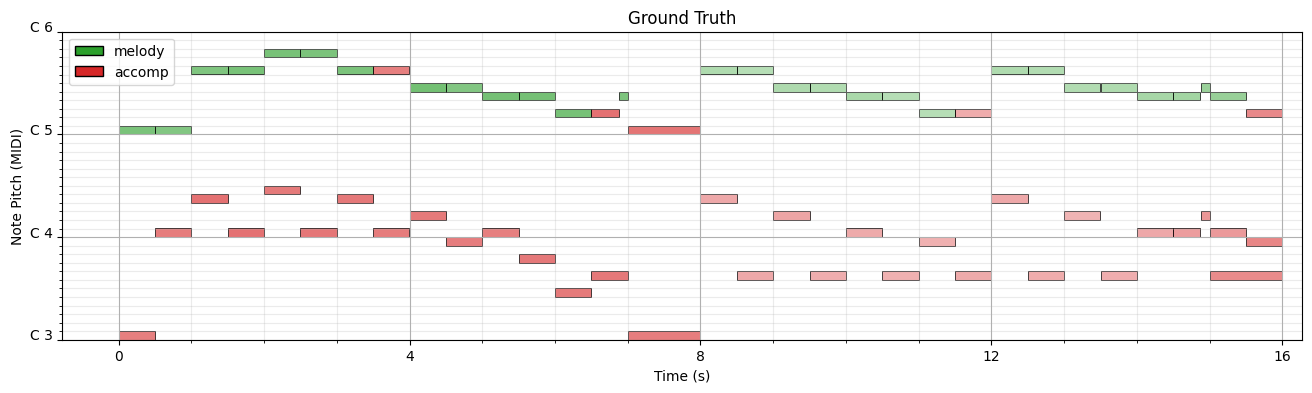

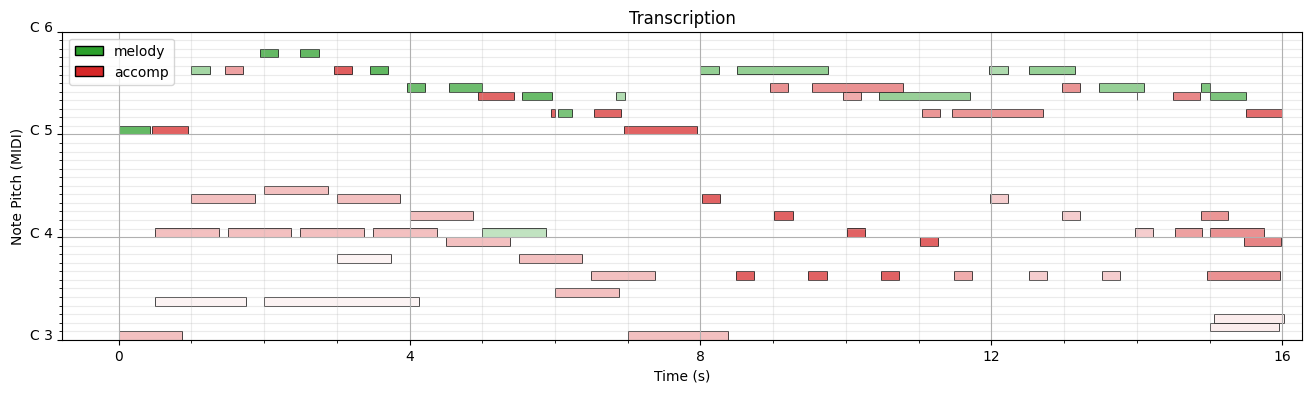

In [13]:
def get_rgba(color, alpha=0.5):
    import matplotlib.colors as mcolors
    if not hasattr(alpha, '__iter__'):
        return mcolors.to_rgb(color) + (alpha,)
    return [mcolors.to_rgb(color) + (a,) for a in alpha]

def get_intervals_from_note_array(note_array):
    return np.array([note_array['onset_sec'], note_array['onset_sec'] + note_array['duration_sec']]).T # shape (n, 2)

def plot_piano_roll(melody, accompaniment, title=''):
    # extract melody and accompaniment intervals and pitch numbers
    # melody_intervals = get_intervals_from_note_array(melody)
    # accomp_intervals = get_intervals_from_note_array(accompaniment)
    # melody_pitch_nums = melody['pitch']
    # accomp_pitch_nums = accompaniment['pitch']
    # melody_vel = melody['velocity'] / 127.
    # accomp_vel = accompaniment['velocity'] / 127.

    # plot the melody and accompaniment with separate colors, omit velocities (irrelevant for timing analysis)
    fig = plt.figure(figsize=(4*4, 1*4))
    ax = plt.gca()

    # kwargs forwarded to Collection: https://matplotlib.org/3.7.0/api/collections_api.html#matplotlib.collections.Collection
    # NOTE: unfortunately, there is no way to pass down the list of facecolors for individual notes (alpha to display velocity)
    # such that mir_eval.display.piano_roll correctly utilizes the values in this list. 
    # argument "facecolors" is completely ignored
    # argument "facecolor" is used but incorrectly (either all notes have the same alpha, or values are shuffled somewhere and then wrongly assigned)
    # below is a hacky way to init piano roll sheet with legend labels, and populate notes as rectangles from note arrays, note by note
    mir_eval.display.piano_roll(
        # melody_intervals, midi=melody_pitch_nums,
        [], midi=[],
        label='melody', facecolor=get_rgba('tab:green', 1.0), edgecolor='black', linewidth=1.0, linestyle='-', hatch=None, ax=ax)
    for note in melody:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:green', note['velocity'] / 127.),
            edgecolor='black', linewidth=0.5, linestyle='-', hatch=None))
    
    mir_eval.display.piano_roll(
        # accomp_intervals, midi=accomp_pitch_nums,
        [], midi=[],
        label='accomp', facecolor=get_rgba('tab:red', 1.0), edgecolor='black', linewidth=1.0, linestyle='-', hatch=None, ax=ax)
    for note in accompaniment:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:red', note['velocity'] / 127.),
            edgecolor='black', linewidth=0.5, linestyle='-', hatch=None))

    # for bbhc in ax.collections:
    #     if bbhc.properties()['label'] == 'melody':
    #         fc = bbhc.get_facecolor()
    #         fc[0][-1] = 0.75
    #         bbhc.set_facecolor(fc)
    #     if bbhc.properties()['label'] == 'accomp':
    #         fc = bbhc.get_facecolor()
    #         fc[0][-1] = 0.75
    #         bbhc.set_facecolor(fc)

    ax.grid(True, which='major')
    ax.grid(True, which='minor', alpha=0.25)
    noterange=(pm.note_name_to_number('C3'), pm.note_name_to_number('C6'))
    ax.set_ybound(lower=noterange[0], upper=noterange[1])
    ax.legend(mode='upper left')

    mir_eval.display.ticker_notes(ax=ax) # replace midi pitch numbers with note names
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=12.0)) # major tick each 12 semitones (1 octave)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=4.0)) # major tick [seconds]
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=1.0)) # minor tick [seconds]
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_xlabel('Time (s)');
    ax.set_ylabel('Note Pitch (MIDI)');
    ax.set_title(title);

    return fig, ax

fig, ax = plot_piano_roll(melody, accompaniment, title='Ground Truth')
fig, ax = plot_piano_roll(melody_pred, accompaniment_pred, title='Transcription')

Plot Both Piano Rolls Together with IOIs time-aligned

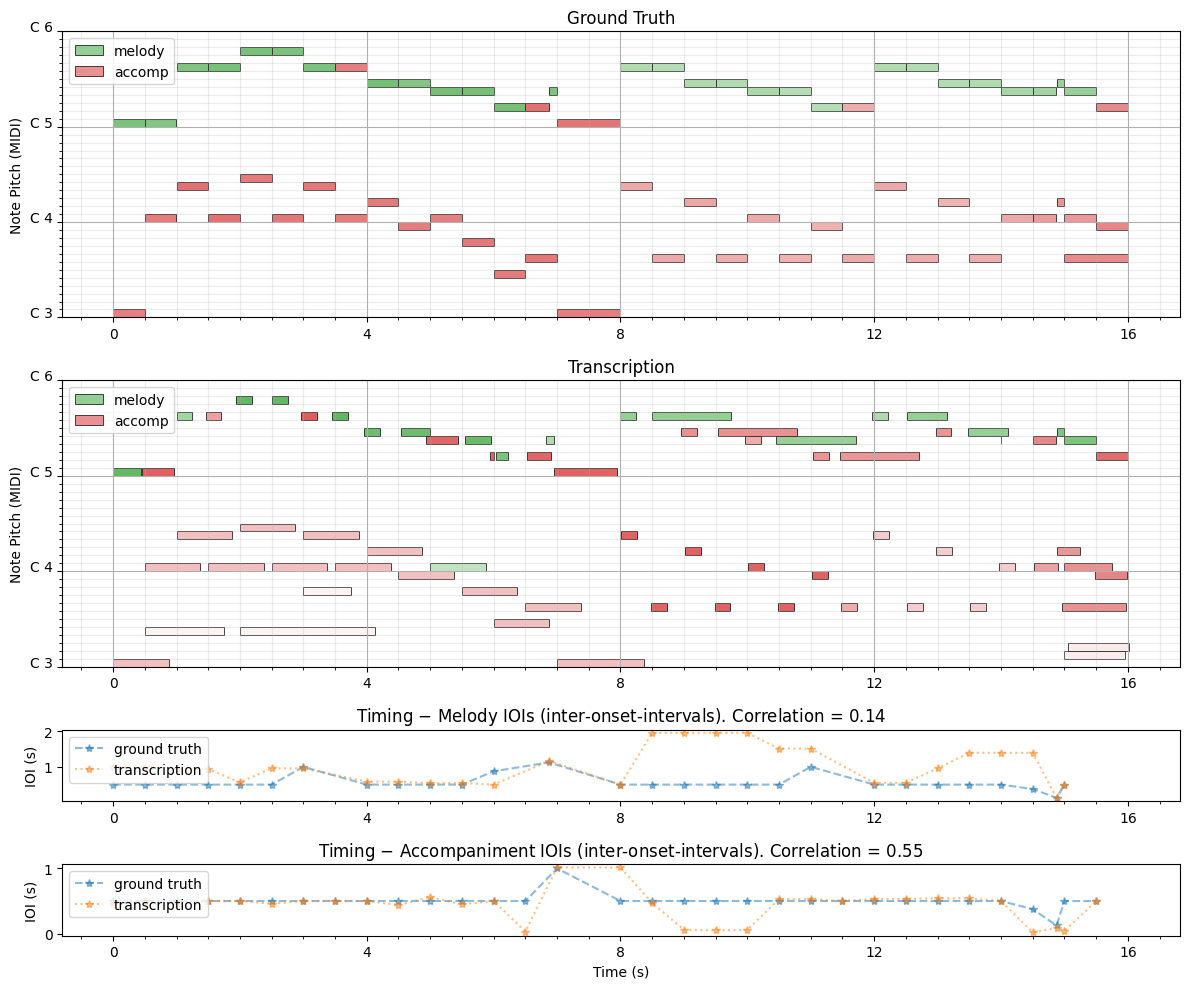

In [14]:
def plot_together_pianorolls_IOIs(
        ref_melody, ref_accomp, pred_melody, pred_accomp,
        melody_onsets, melody_ioi_ref, melody_ioi_pred,
        accomp_onsets, accomp_ioi_ref, accomp_ioi_pred,
        title='',
        ):
    # plot the melody and accompaniment with separate colors, velocity as alpha
    fig, axs = plt.subplots(4, 1, figsize=(16-4, 8+2), sharex=True, gridspec_kw={'height_ratios': [4, 4, 1, 1]})
    # kwargs forwarded to Collection: https://matplotlib.org/3.7.0/api/collections_api.html#matplotlib.collections.Collection

    lw = 0.5
    alpha = 0.5

    # ground truth
    ax = axs[0]

    mir_eval.display.piano_roll([], midi=[],
        label='melody', facecolor=get_rgba('tab:green', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_melody:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:green', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
        
    mir_eval.display.piano_roll([], midi=[],
        label='accomp', facecolor=get_rgba('tab:red', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_accomp:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:red', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    
    # transcription
    ax = axs[1]

    mir_eval.display.piano_roll([], midi=[],
        label='melody', facecolor=get_rgba('tab:green', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_melody:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:green', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    
    mir_eval.display.piano_roll([], midi=[],
        label='accomp', facecolor=get_rgba('tab:red', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_accomp:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:red', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))

    for ax in [axs[0], axs[1]]:
        ax.grid(True, which='major')
        ax.grid(True, which='minor', alpha=0.25)
        noterange=(pm.note_name_to_number('C3'), pm.note_name_to_number('C6'))
        ax.set_ybound(lower=noterange[0], upper=noterange[1])
        ax.legend(loc='upper left')

        mir_eval.display.ticker_notes(ax=ax) # replace midi pitch numbers with note names
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=12.0)) # major tick each 12 semitones (1 octave)
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=4.0)) # major tick [seconds]
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.5)) # minor tick [seconds]
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.set_ylabel('Note Pitch (MIDI)');
        # ax.set_xlabel('Time (s)');
    
    axs[0].set_title('Ground Truth');
    axs[1].set_title('Transcription');

    # IOIs
    melody_ioi_corr = np.corrcoef(melody_ioi_ref, melody_ioi_pred)[0, 1]
    accomp_ioi_corr = np.corrcoef(accomp_ioi_ref, accomp_ioi_pred)[0, 1]

    ax = axs[2]
    ax.plot(melody_onsets, melody_ioi_ref, alpha=.5, linestyle='--', marker='*', label='ground truth')
    ax.plot(melody_onsets, melody_ioi_pred, alpha=.5, linestyle=':', marker='*', label='transcription')
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('IOI (s)')
    ax.set_title(f'Timing $-$ Melody IOIs (inter-onset-intervals). Correlation = {melody_ioi_corr:.2f}')
    ax.legend(loc='upper left')
    
    ax = axs[3]
    ax.plot(accomp_onsets, accomp_ioi_ref, alpha=.5, linestyle='--', marker='*', label='ground truth')
    ax.plot(accomp_onsets, accomp_ioi_pred, alpha=.5, linestyle=':', marker='*', label='transcription')
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('IOI (s)')
    ax.set_title(f'Timing $-$ Accompaniment IOIs (inter-onset-intervals). Correlation = {accomp_ioi_corr:.2f}')
    ax.legend(loc='upper left')

    ax.set_xlabel('Time (s)');

    fig.tight_layout()
    
    return fig, axs

fig, axs = plot_together_pianorolls_IOIs(
    melody, accompaniment, melody_pred, accompaniment_pred,
    melody_onsets, melody_ioi_ref, melody_ioi_pred,
    accompaniment_onsets, accompaniment_ioi_ref, accompaniment_ioi_pred,
    title='Running example for illustrating computation of our Musically Informed Metrics')
# supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp
fig.savefig('../poster/poster_fig1_timing.pdf', bbox_inches='tight')